# 导入函数库

In [1]:
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds # 这个就是刚才所说的Tensorflow Datasets
import tensorflow as tf

# 数据加载

## 一般采用这个写法

In [2]:
(raw_test, raw_train), metadata = tfds.load(
    'rock_paper_scissors', # 数据集名称，这个是手势识别分类数据集，共3个类别
    split=['test', 'train'], # 这里的raw_test和split的'test'对应，raw_train和split的'train'对应
    with_info=True, # 这个参数和metadata对应
    as_supervised=True, # 这个参数的作用是返回tuple形式的(input, label),举个例子，raw_test=tuple(input, label)
    shuffle_files=True  # 对数据进行扰乱操作，可以自己体会下设置成False时，下面imshow的时候的结果差别
)

## 进行展示

In [3]:
raw_train # 下面的shape的意思是每张图片的height=300, width=300, channel=3(RGB三通道)，label是个scalar

<_OptionsDataset shapes: ((300, 300, 3), ()), types: (tf.uint8, tf.int64)>

In [4]:
raw_test

<_OptionsDataset shapes: ((300, 300, 3), ()), types: (tf.uint8, tf.int64)>

In [5]:
metadata # 包含数据集的一些信息

tfds.core.DatasetInfo(
    name='rock_paper_scissors',
    version=3.0.0,
    description='Images of hands playing rock, paper, scissor game.',
    homepage='http://laurencemoroney.com/rock-paper-scissors-dataset',
    features=FeaturesDict({
        'image': Image(shape=(300, 300, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
    }),
    total_num_examples=2892,
    splits={
        'test': 372,
        'train': 2520,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {rps,
    author = "Laurence Moroney",
    title = "Rock, Paper, Scissors Dataset",
    month = "feb",
    year = "2019",
    url = "http://laurencemoroney.com/rock-paper-scissors-dataset"
    }""",
    redistribution_info=,
)

# 转化成Numpy array

我们知道数据存在的方式主要有两种，numpy array这个在matplotlib等函数库中是用于做imshow的，另外一种tensor主要用于Tensorflow等框架进行训练用的

In [6]:
raw_train_numpy = tfds.as_numpy(raw_train)

In [7]:
raw_train_numpy  # 我们发现这里的raw_train_numpy是一个generator

<generator object _eager_dataset_iterator at 0x7f772c5cb0a0>

## 数据集数量验证

此处用的是'rock_paper_scissors'数据集，train_num=2520, test_num=372

In [8]:
# 这里是为了验证raw_train和raw_test是不是得到了正确的训练集和测试集
count = 0
for i, data in enumerate(raw_train_numpy):
    count += 1

In [9]:
count

2520

In [10]:
data[0].shape

(300, 300, 3)

In [11]:
data[1] # 看到了吧，这里是一个scalar

1

# 可视化两张图片

可以通过这个来间接判断图片的height和width，虽然有些图片的height和width变动范围比较大

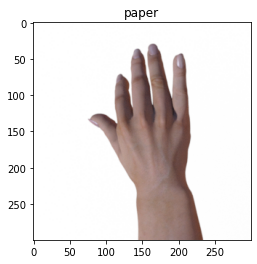

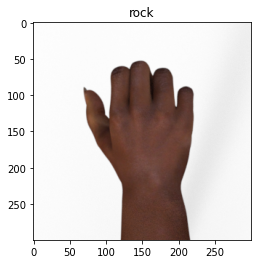

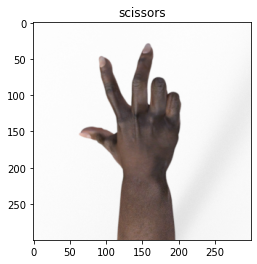

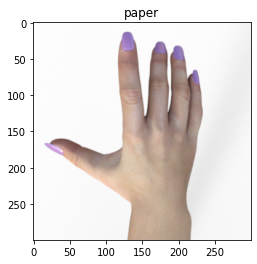

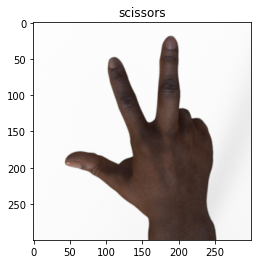

In [12]:
get_label_name = metadata.features['label'].int2str

# 可以理解为迭代出5个batch，但是这里特殊点儿，因为之前并没对数据进行batch处理，所以其实是迭代出5张图片，和下面可视化出来的5个图片对应
for image, label in raw_train.take(5): 
    plt.figure()
    plt.imshow(image)
    plt.title(get_label_name(label))

In [13]:
image # 我们可以看到数据是int8，我们需要转化成float32

<tf.Tensor: shape=(300, 300, 3), dtype=uint8, numpy=
array([[[254, 254, 254],
        [253, 253, 253],
        [254, 254, 254],
        ...,
        [251, 251, 251],
        [250, 250, 250],
        [250, 250, 250]],

       [[254, 254, 254],
        [254, 254, 254],
        [253, 253, 253],
        ...,
        [250, 250, 250],
        [251, 251, 251],
        [249, 249, 249]],

       [[254, 254, 254],
        [254, 254, 254],
        [254, 254, 254],
        ...,
        [251, 251, 251],
        [250, 250, 250],
        [252, 252, 252]],

       ...,

       [[252, 252, 252],
        [251, 251, 251],
        [252, 252, 252],
        ...,
        [247, 247, 247],
        [249, 249, 249],
        [248, 248, 248]],

       [[253, 253, 253],
        [253, 253, 253],
        [251, 251, 251],
        ...,
        [248, 248, 248],
        [248, 248, 248],
        [248, 248, 248]],

       [[252, 252, 252],
        [253, 253, 253],
        [252, 252, 252],
        ...,
        [248, 248, 24

# 对数据进行预处理

In [14]:
IMG_SIZE = 300 # 所有的图片都会被resize到300x300

# 定义一个函数，对每个(image, label)进行处理
def format_example(image, label):
    image = tf.cast(image, tf.float32) # 转化成float32
    image = (image/127.5) - 1 # 数据缩放到[-1,1]
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

In [15]:
# 对每一个样本进行处理
train = raw_train.map(format_example)
test = raw_test.map(format_example)

## 后面模型训练要用到的是train_batches和test_batches

In [16]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

In [17]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [18]:
train_batches

<BatchDataset shapes: ((None, 300, 300, 3), (None,)), types: (tf.float32, tf.int64)>

# 这里的prefetch可以加快模型训练速度

In [19]:
import tensorflow as tf
import tensorflow_datasets as tfds

# 构建一个tf.data.Dataset
ds = tfds.load('mnist', split='train', shuffle_files=True)

# 构建data pipeline
ds = ds.shuffle(1024).batch(32).cache().prefetch(tf.data.experimental.AUTOTUNE) # 此处的cache和prefetch能加速模型训练
for example in ds.take(1):
    image, label = example['image'], example['label']

In [20]:
image

<tf.Tensor: shape=(32, 28, 28, 1), dtype=uint8, numpy=
array([[[[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        ...,

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]]],


       [[[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        ...,

        [[0],
 

In [21]:
label

<tf.Tensor: shape=(32,), dtype=int64, numpy=
array([2, 7, 4, 3, 3, 9, 6, 0, 0, 8, 8, 3, 2, 4, 8, 8, 1, 9, 9, 1, 6, 2,
       7, 6, 4, 3, 4, 6, 4, 5, 1, 2])>